<a href="https://colab.research.google.com/github/karkarinps/ML-jupyter/blob/main/Torchvision_testTask_231022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!unzip '/content/sample_data/yesno.zip' -d '/content/dataset'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/dataset/train/yes/frame2502.jpg  
  inflating: /content/dataset/train/yes/frame2503.jpg  
  inflating: /content/dataset/train/yes/frame2504.jpg  
  inflating: /content/dataset/train/yes/frame2505.jpg  
  inflating: /content/dataset/train/yes/frame2506.jpg  
  inflating: /content/dataset/train/yes/frame2507.jpg  
  inflating: /content/dataset/train/yes/frame2508.jpg  
  inflating: /content/dataset/train/yes/frame2509.jpg  
  inflating: /content/dataset/train/yes/frame251.jpg  
  inflating: /content/dataset/train/yes/frame2510.jpg  
  inflating: /content/dataset/train/yes/frame2511.jpg  
  inflating: /content/dataset/train/yes/frame2512.jpg  
  inflating: /content/dataset/train/yes/frame2513.jpg  
  inflating: /content/dataset/train/yes/frame2514.jpg  
  inflating: /content/dataset/train/yes/frame2515.jpg  
  inflating: /content/dataset/train/yes/frame2516.jpg  
  inflating: /content/dataset/train/y

In [ ]:
def image_shower(images, labels, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))

classes = ("no", "yes")

PATH = "/content/dataset"

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((116,116)),
     transforms.ToTensor(),   
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) 


trainset = torchvision.datasets.ImageFolder(os.path.join(PATH, "train"), transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=0, shuffle=True)

testset = torchvision.datasets.ImageFolder(os.path.join(PATH, "test"), transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=0, shuffle=True)

Real Labels:    yes   yes    no   yes


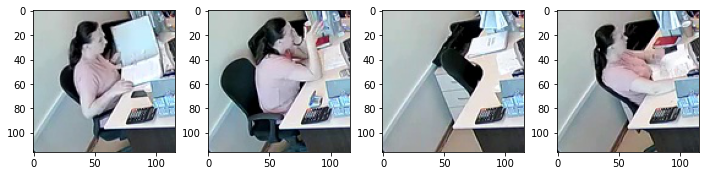

In [ ]:
images, labels = next(iter(trainloader))
image_shower(images, labels)

In [ ]:
model = torchvision.models.resnet152(pretrained=True)

for param in model.parameters():
    param.require = False

model.fc = nn.Linear(2048, 2)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
epochs = 7  
model.to(device) 

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader)):
        #каждый батч тоже помещаем на GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        #сбрасываем накопленный градиент 
        optimizer.zero_grad()
        #прогоняем изображения через модель, чтобы получить предсказание
        outputs = model(inputs)
        #рассчитываем функцию потерь (насколько хорошо предсказали)
        loss = criterion(outputs, labels)
        #считаем градиенты (обратный проход)
        loss.backward()
        #делаем шаг оптимизатора (обновляем веса)
        optimizer.step()

        running_loss += loss.item()

    print ("Epoch {} - Training loss: {} ".format(epoch, running_loss/len(trainloader)))

167it [01:35,  1.74it/s]


Epoch 0 - Training loss: 0.012152295104129452 


167it [01:36,  1.74it/s]


Epoch 1 - Training loss: 1.749387357959339e-05 


167it [01:36,  1.73it/s]


Epoch 2 - Training loss: 6.2983239439415885e-06 


167it [01:36,  1.72it/s]


Epoch 3 - Training loss: 3.5744633655626868e-06 


167it [01:36,  1.73it/s]


Epoch 4 - Training loss: 3.808275911456711e-06 


167it [01:36,  1.72it/s]


Epoch 5 - Training loss: 2.2083423754771546e-06 


167it [01:36,  1.72it/s]

Epoch 6 - Training loss: 3.025371436793644e-06 


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    #переводим модель в режим инференса
    model.eval()
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        #получаем наши предсказания
        _, predicted = torch.max(outputs.data, 1)
        #посчитаем общее количество картинок
        total += labels.size(0)
        #посчитаем количество точно классифицированных картинок
        correct += (predicted == labels).sum().item()
print("Accuracy: %d" %(100 * correct/total))

Accuracy: 100


Real Labels:    yes   yes   yes    no
Predicted:    yes   yes   yes    no


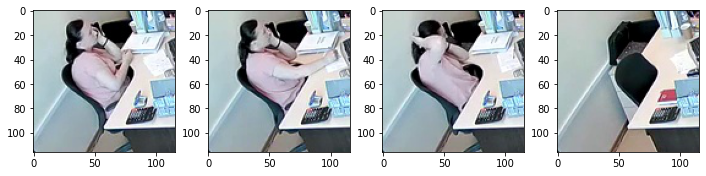

In [ ]:
images, labels = next(iter(testloader))
image_shower(images, labels)

outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" %classes[predict] for predict in predicted[:4]))

In [ ]:
torch.save(model.state_dict(), '/content/dataset/checkpoint.pth')

In [ ]:
torch.save(model, '/content/dataset/model.pth')